# Fitting relaxometry data
Let's start by looking at data from one of the given files

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

/home/carlosm/venvs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
group = pd.read_csv('./data/sample.csv', index_col='TI')

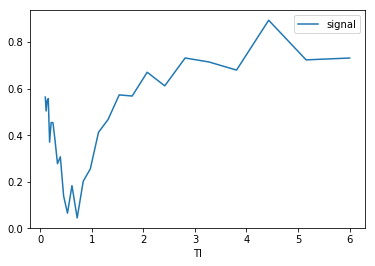

In [4]:
group.plot()

In [5]:
groupArray = group.reset_index().values

In [6]:
time = groupArray[:,0]
signal = groupArray[:,1]

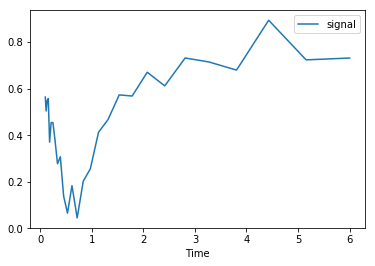

In [7]:
plot(time, signal, label='signal')
xlabel('Time')
legend()

# Parameter estimation
Let's build some perfect synthetic data

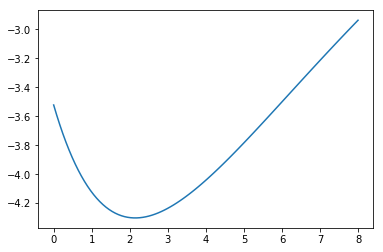

In [8]:
def modelFunction(a, b, time):
    return a * np.exp(-time / 2) - b * np.exp(-(time - 0.1) / 10.)

nSamples = 100
t = np.linspace(0, 8, nSamples)
# t = np.logspace(np.log(0.0001), np.log(8), nSamples)


a = np.pi
b = np.pi * 2.1
true_signal = modelFunction(a, b, t)
plot(t,true_signal)

In [9]:
from scipy.stats import norm

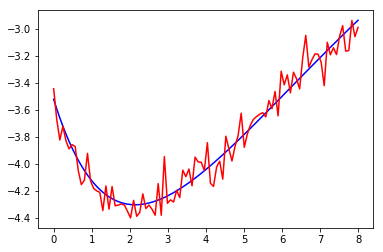

In [10]:
noise = norm.rvs(loc=0, scale=0.1, size=nSamples)
noisy_signal = true_signal + noise

plot(t, true_signal, 'b-')
plot(t, noisy_signal, 'r-')

# Let's find parameters which fit our data
Solve using `scipy.linalg.lstsq` or for `numpy.linalg.lstsq` or `lmfit`

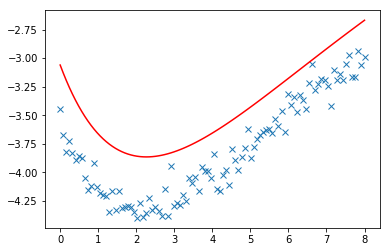

In [11]:
# Naive method -- trial and error

shift_guess = 3
freq_guess = 6

guessed_signal = modelFunction(shift_guess, freq_guess, t)

plot(t, noisy_signal, 'x')
plot(t, guessed_signal, 'r-')

We can do better than manually fitting our parameters

In [12]:
import lmfit # https://lmfit.github.io/lmfit-py/

In [13]:
def errorFunction(signal, target_signal):
    return abs(target_signal - signal)

In [14]:
def costFunction(params, t, target_signal):
    a = params['a'].value
    b = params['b'].value

    signal = modelFunction(a, b, t)

    return errorFunction(signal, target_signal)

In [15]:
fitParams = lmfit.Parameters()
fitParams.add('a', min=0, max=10, value=5)
fitParams.add('b', min=0, max=10, value=5)

In [16]:
result = lmfit.minimize(costFunction, fitParams, args=(t, noisy_signal))

print('a = %.4f'%result.params['a'].value,'(ground truth = %.2f)'%a)
print('b = %.4f'%result.params['b'].value,'(ground truth = %.2f)'%b)

a = 3.0722 (ground truth = 3.14)
b = 6.5748 (ground truth = 6.60)


In [17]:
lmfit.report_fit(result.params)

[[Variables]]
    a:  3.07221571 +/- 0.04772684 (1.55%) (init = 5)
    b:  6.57476002 +/- 0.02398398 (0.36%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.826


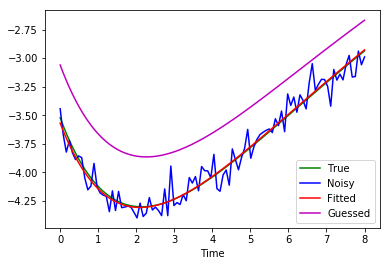

In [18]:
a = result.params['a']
b = result.params['b']

fitted_signal = modelFunction(a, b, t)

plot(t, true_signal   , 'g-', label='True')
plot(t, noisy_signal  , 'b-', label='Noisy')
plot(t, fitted_signal, 'r-', label='Fitted')
plot(t, guessed_signal, 'm-', label='Guessed')

xlabel('Time')
legend()

# Quick look at the noise


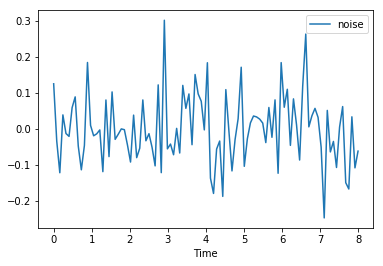

In [19]:
error = noisy_signal - fitted_signal
plot(t,error, label='noise')
xlabel('Time')
legend()

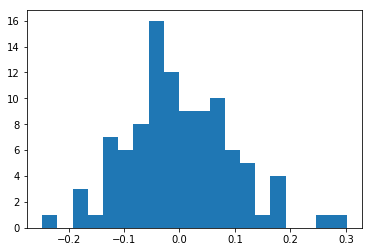

In [20]:
hist(error, bins=20);

In [21]:
def buildNoisySample():
    a = np.pi
    b = np.pi * 2.1
    nSamples = 100
    t = np.linspace(0, 8, nSamples)
    
    true_signal = modelFunction(a, b, t)
    noise = norm.rvs(loc=0, scale=0.05, size=nSamples)
    noisy_signal = true_signal + noise
    return t, noisy_signal


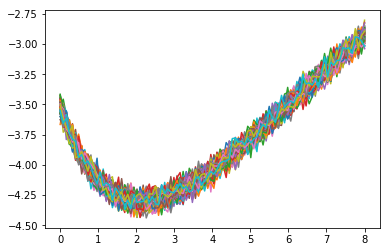

In [22]:
allErrors = []
for i in range(100):
    t, noisy_signal = buildNoisySample()
    plot(t, noisy_signal)
    error = noisy_signal - fitted_signal
    allErrors += error.tolist()

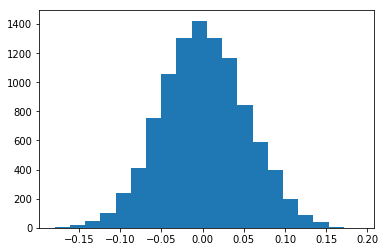

In [23]:
hist(allErrors, bins=20);

In [24]:
loc,scale = norm.fit(allErrors)
print('Guessed noise characteristics: ')
print('Loc  : %.4f'%loc)
print('Scale: %.4f'%scale)


Guessed noise characteristics: 
Loc  : 0.0016
Scale: 0.0518


# Assignment -- tips
 - Load the data corresponding to your group `./data/group_N.csv`, as we did with the sample
 - Build your model function according to she simplified model:
 
$$
 M_z = M_0 \left| 1 - 2 exp \left( - \dfrac{TI}{T1} \right) \right| 
$$

So there are two parameters to fit: $TI$ and $M_0$.
 
 